In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import transforms
import matplotlib.ticker as plticker
from matplotlib import rcParams

# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Helvetica']
rcParams['axes.linewidth'] = 1.5
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [10]:
raw_df_4090 = pd.concat(
    [
        pd.read_csv("benchmark-4-12-2023.csv"),
        pd.read_csv("opt-benchmark.csv"),
        pd.read_csv("specinfer-benchmark.csv"),
    ],
    ignore_index=True,
)
raw_df_4090["speed"] = 1000 / raw_df_4090["latency"]
raw_df_4090 = raw_df_4090.drop(columns=["latency"])

In [11]:
raw_df_2080 = pd.concat(
    [
        pd.read_csv("benchmark-19-4-2024-2080ti.csv"),
        pd.read_csv("opt-benchmark-2080ti.csv"),
        pd.read_csv("specinfer-benchmark-2080ti.csv"),
    ],
    ignore_index=True,
)
raw_df_2080["speed"] = 1000 / raw_df_2080["latency"]
raw_df_2080 = raw_df_2080.drop(columns=["latency"])

In [14]:
def map_model_file_name(fn):
    match fn.split("-"):
        case ["bamboo", w, *_]:
            return f"Bamboo {w.upper()}"
        case ["llama", w, *_]:
            return f"LLaMA2(ReGLU) {w.upper()}"
        case ["opt", w, *_]:
            if w == "6.7b":
                w = "7b"
            return f"OPT {w.upper()}"
        case ["falcon", "40b", *_]:
            return "Falcon(ReLU) 40B"
        case _:
            raise ValueError

model_idx = {
    "Bamboo 7B": 0,
    "OPT 13B": 1,
    "OPT 30B": 2,
    "OPT 66B": 3,
    "OPT 175B": 4,
    "Falcon(ReLU) 40B": 5,
    "LLaMA2(ReGLU) 13B": 6,
    "LLaMA2(ReGLU) 70B": 7,
    "OPT 7B": 8,
}



def extract_bench_df(raw_df: pd.DataFrame, with_quantization=False):
    _quant_idx = raw_df.model.str.contains("\.q4")
    _powerinfer_idx = raw_df.model.str.contains("powerinfer")
    _spec_idx = raw_df.model.str.contains("specinfer")

    if with_quantization:
        raw_df = raw_df[_quant_idx]
    else:
        raw_df = raw_df[~_quant_idx]

    baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
    baseline_df["model"] = baseline_df.model.apply(map_model_file_name)

    ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
    ours_df["model"] = ours_df.model.apply(map_model_file_name)

    spec_df = raw_df[_spec_idx].reset_index(drop=True)
    spec_df["model"] = spec_df.model.apply(map_model_file_name)

    bench_df = pd.merge(
        ours_df,
        baseline_df,
        how="outer",
        on=["model", "input", "output"],
        suffixes=("", "_baseline"),
    )
    bench_df = pd.merge(
        bench_df,
        spec_df,
        how="outer",
        on=["model", "input", "output"],
        suffixes=("", "_spec"),
    )

    bench_df["_model_idx"] = bench_df.model.apply(lambda x: model_idx[x])

    bench_df.loc[
        bench_df.speed.isna() & bench_df.speed_baseline.isna(),
        "speed_baseline",
    ] = 1
    return bench_df

In [15]:
baseline_color = "#f19e38"
ours_color = "#0080ff"
spec_color = "#ffdd00"

def draw_model_speedup_plot_under_input(
    df_under_input: pd.DataFrame,
    ax,
    with_xticklabels=False,
    with_model_caption=False,
    ylim=10,
    y_grid_freq=2,
    side_notes=None,
):
    pivot_df = (
        df_under_input.pivot_table(
            index=["model", "output"],
            values=["speed_baseline", "speed_spec", "speed", "_model_idx"],
            aggfunc="mean",
        )
        .sort_values("_model_idx")
        .reset_index()
    )
    models = pivot_df.model.unique()
    output_lens = pivot_df.output.unique()

    # Bar plot layout adjustments
    bar_width = 0.1
    bars_gap = 0.1
    comparing_bars_gap = 0.15  # Adjusted for three bars
    comparing_bars_width = bar_width * 3 + bars_gap * 2 + comparing_bars_gap

    group_gap = 0.2
    group_width = comparing_bars_width * len(output_lens) + group_gap * (len(output_lens) - 1)

    xticks = np.array(
        [
            (im * group_width) + (ic * comparing_bars_width)
            for im in range(len(models))
            for ic in range(len(output_lens))
        ]
    )

    for x_center, (il, pivot_line) in zip(xticks, pivot_df.iterrows()):
        x1 = x_center - bar_width - bars_gap
        x2 = x_center
        x3 = x_center + bar_width + bars_gap
        
        speedup_spec = pivot_line.speed_spec / pivot_line.speed_baseline
        speedup_ours = pivot_line.speed / pivot_line.speed_baseline

        ax.bar(
            x=[x1, x2, x3],
            height=[1, speedup_spec, speedup_ours],
            width=bar_width,
            color=[baseline_color, spec_color, ours_color],
            edgecolor="black",
            linewidth=1,
            zorder=3,
        )

        # Formatting and annotating speeds
        format_speed = lambda x: "{:.0f}".format(x) if x >= 10 else "{:.1f}".format(x) if x > 0 else "x"
        ax.text(x1, 1 + 0.3, format_speed(pivot_line.speed_baseline), ha="center", va="bottom", fontsize=11.3, color="black", rotation=90)
        ax.text(x2, speedup_spec + 0.3, format_speed(pivot_line.speed_spec), ha="center", va="bottom", fontsize=12, color="black", rotation=90)
        ax.text(x3, speedup_ours + 0.3, format_speed(pivot_line.speed), ha="center", va="bottom", fontsize=12, color="black", rotation=90)

    # Additional updates to ticks and labels
    ax.set_xticks(xticks)
    if with_xticklabels:
        ax.set_xticklabels(np.tile(output_lens, len(models)), rotation=30)
    else:
        ax.set_xticklabels([""] * len(xticks))

    # Model labels and vertical lines for grouping
    ax.set_xlabel("")
    group_label_pos = xticks.reshape(-1, len(output_lens)).mean(axis=1)
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    if with_model_caption:
        for pos, label in zip(group_label_pos, models):
            ax.text(pos, 0.95, label, transform=trans, ha="center", color="steelblue", va="top", fontsize=11)
    for pos in (group_label_pos[:-1] + group_label_pos[1:]) / 2:
        ax.axvline(pos, 0, 1.0, color="steelblue", ls=":", clip_on=False)

    ax.set_ylabel("Speedup", fontsize=14, labelpad=1)
    ax.set_ylim(0, ylim + (2 if with_model_caption else 0))
    ax.yaxis.set_major_locator(plticker.MultipleLocator(base=y_grid_freq))
    ax.tick_params(axis="both", which="both", direction="in", labelsize=14)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, color="gray", zorder=0)

    return ax


def draw_speedup_plots(
    bench_df: pd.DataFrame,
    figsize=(8, 3),
    input_lens=[64],
    speedup_ylim=4,
    output_path=None,
    with_legend=True,
    y_grid_freq=2,
    side_notes=None,
    postprocess=False
):
    _, axes = plt.subplots(len(input_lens), 1, figsize=figsize)
    if not isinstance(axes, np.ndarray):
        axes = [axes]
    for ax, input_len in zip(axes, input_lens):
        if ax == axes[0] and with_legend:
            # floating legend of (baselines, ours)
            legend = ax.legend(
                handles=[
                    plt.Rectangle(
                        (0, 0),
                        1,
                        1,
                        facecolor=baseline_color,
                        edgecolor="black",
                        linewidth=1,
                    ),
                    plt.Rectangle(
                        (0, 0),
                        1,
                        1,
                        facecolor=spec_color,
                        edgecolor="black",
                        linewidth=1,
                    ),
                    plt.Rectangle(
                        (0, 0),
                        1,
                        1,
                        facecolor=ours_color,
                        edgecolor="black",
                        linewidth=1,
                    ),
                ],
                labels=["llama.cpp", "SpecInfer", "PowerInfer"],
                loc="upper center",
                bbox_to_anchor=(0.5, 1.35),
                ncol=3,
                frameon=False,
                fontsize=13,
            )
            frame = legend.get_frame()
            frame.set_linewidth(1.0)
            frame.set_edgecolor("black")

        # ax.set_title(f'Input length:{input_len}')
        ax = draw_model_speedup_plot_under_input(
            bench_df[bench_df.input == input_len],
            ax=ax,
            with_xticklabels=(ax == axes[-1]),
            with_model_caption=(ax == axes[0]),
            ylim=speedup_ylim,
            y_grid_freq=y_grid_freq,
        )
        # add floating text rotate at right x axis with -90 degrees indicating input length
        ax.text(
            1.02,
            0.5,
            side_notes or f"Input length={input_len}",
            transform=ax.transAxes,
            rotation=-90,
            ha="center",
            va="center",
            fontsize=12,
        )
        if ax == axes[-1]:
            ax.set_xlabel("Output length", fontsize=14)

    if postprocess:
        return axes

    plt.tight_layout()
    plt.savefig(output_path)
    plt.show()


/tmp/ipykernel_2141846/686959470.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/tmp/ipykernel_2141846/686959470.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/tmp/ipykernel_2141846/686959470.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 's

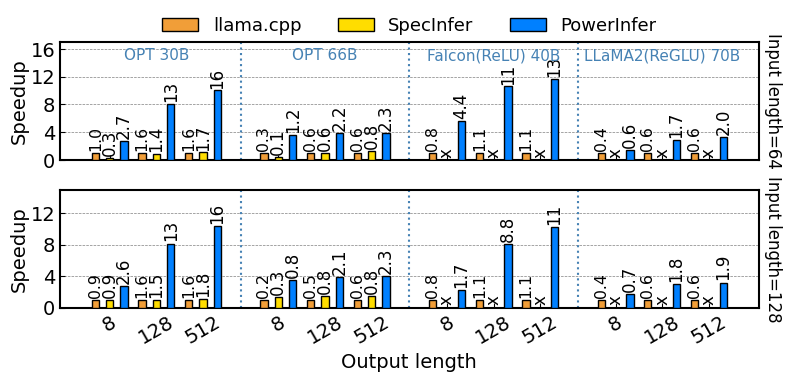

In [16]:
# 4090, no quantization
bench_df = extract_bench_df(raw_df_4090, with_quantization=False)

bench_df = bench_df[bench_df.model != "LLaMA2(ReGLU) 13B"]
bench_df["speed_spec"] = bench_df.speed_spec.fillna(0)
draw_speedup_plots(
    bench_df,
    figsize=(8, 4),
    input_lens=[64, 128],
    speedup_ylim=15,
    y_grid_freq=4,
    output_path="../figures/test-4090.eps",
)

In [17]:
bench_df[(bench_df.model == "Falcon 40B") & (bench_df.output == 512)]

Empty DataFrame
Columns: [model, input, output, speed, speed_baseline, speed_spec, _model_idx]
Index: []

/tmp/ipykernel_2141846/686959470.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/tmp/ipykernel_2141846/686959470.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/tmp/ipykernel_2141846/686959470.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 's

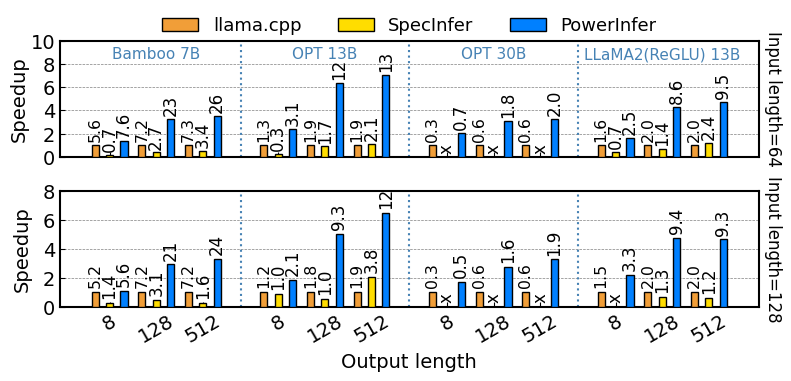

In [18]:
# 2080Ti, no quantization
bench_df = extract_bench_df(raw_df_2080, with_quantization=False)
bench_df = bench_df[bench_df.model != "OPT 7B"]
bench_df["speed_spec"] = bench_df.speed_spec.fillna(0)

axes = draw_speedup_plots(
    bench_df,
    figsize=(8, 4),
    input_lens=[64, 128],
    speedup_ylim=8,
    postprocess=True
)
axes[1].set_ylabel("Speedup", fontsize=14, labelpad=8)
plt.tight_layout()
plt.savefig("../figures/test-2080ti.eps")

/tmp/ipykernel_1019543/686959470.py:40: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/tmp/ipykernel_1019543/686959470.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/tmp/ipykernel_1019543/686959470.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)


AttributeError: 'Series' object has no attribute 'speed_spec'

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

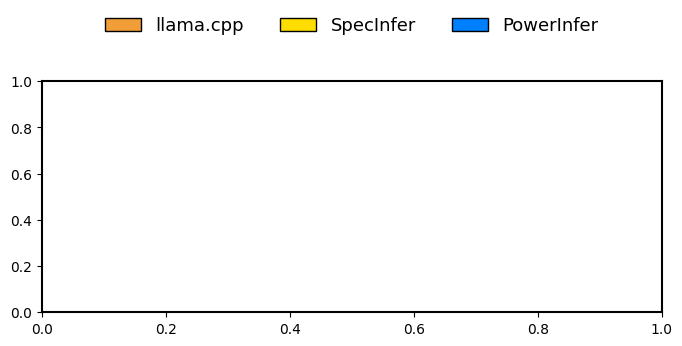

In [60]:
# 4090 with Q4 quantization
bench_df = extract_bench_df(raw_df_4090, with_quantization=True)

draw_speedup_plots(
    bench_df,
    figsize=(8, 3),
    input_lens=[8],
    speedup_ylim=4,
    side_notes="PC-High",
    output_path="../figures/test-4090-q4.eps",
)

/tmp/ipykernel_2683436/3062188009.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/tmp/ipykernel_2683436/3062188009.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/tmp/ipykernel_2683436/3062188009.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)


AttributeError: 'Series' object has no attribute 'speed_spec'

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

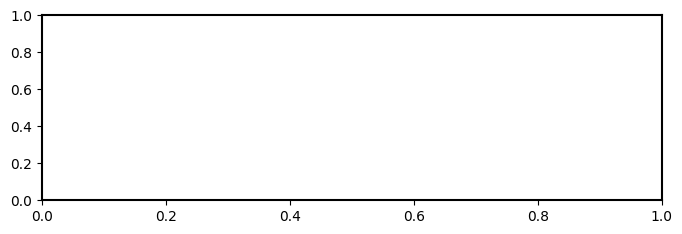

In [ ]:
# 2080Ti with Q4 quantization
bench_df = extract_bench_df(raw_df_2080, with_quantization=True)

draw_speedup_plots(
    bench_df,
    figsize=(8, 2.4),
    input_lens=[8],
    speedup_ylim=9,
    side_notes="PC-Low",
    output_path="../figures/test-2080ti-q4.eps",
    with_legend=False,
)

In [ ]:
bench_df = extract_bench_df(raw_df_4090)
bench_df = bench_df[bench_df.input == 64]
bench_df = bench_df[bench_df.output == 512]
bench_df = bench_df[bench_df.model != "LLaMA 13B"]
bench_df['speedup'] = bench_df.speed / bench_df.speed_baseline
bench_df['speedup_spec'] = bench_df.speed / bench_df.speed_spec
bench_df

/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)


model  input  output      speed  speed_baseline  speed_spec  \
5    LLaMA 70B     64     512   1.950226        0.595497         NaN   
14  Falcon 40B     64     512  12.941968        1.107400         NaN   
23     OPT 30B     64     512  16.059097        1.603875    1.722775   
32     OPT 66B     64     512   2.314011        0.588339    0.754919   

    _model_idx    speedup  speedup_spec  
5            7   3.274957           NaN  
14           5  11.686804           NaN  
23           2  10.012687      9.321648  
32           3   3.933125      3.065246

In [ ]:
bench_df[['speed', 'speed_baseline', 'speedup', 'speedup_spec']].agg(['mean', 'std', 'max'])

speed  speed_baseline    speedup  speedup_spec
mean   8.316326        0.973778   7.226893      6.193447
std    7.254931        0.485296   4.247280      4.423944
max   16.059097        1.603875  11.686804      9.321648

In [ ]:
bench_df = extract_bench_df(raw_df_2080)
bench_df = bench_df[bench_df.input == 64]
bench_df = bench_df[bench_df.output == 512]
bench_df['speedup'] = bench_df.speed / bench_df.speed_baseline
bench_df['speedup_spec'] = bench_df.speed / bench_df.speed_spec
bench_df

/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)


model  input  output      speed  speed_baseline  speed_spec  \
5   LLaMA 13B     64     512   9.502542        2.015227    2.408275   
14  Bamboo 7B     64     512  25.533653        7.285019    3.418032   
23     OPT 7B     64     512  36.791759        7.408139         NaN   
32    OPT 13B     64     512  13.351135        1.889954    2.058439   
41    OPT 30B     64     512   2.022081        0.617120         NaN   

    _model_idx   speedup  speedup_spec  
5            6  4.715370      3.945788  
14           0  3.504954      7.470279  
23           8  4.966397           NaN  
32           1  7.064263      6.486048  
41           2  3.276641           NaN

In [ ]:
bench_df[['speed', 'speed_baseline', 'speedup', 'speedup_spec']].agg(['mean', 'std', 'max'])

speed  speed_baseline   speedup  speedup_spec
mean  17.440234        3.843092  4.705525      5.967372
std   13.760742        3.244964  1.509543      1.818592
max   36.791759        7.408139  7.064263      7.470279

In [ ]:
bench_df = extract_bench_df(raw_df_4090, with_quantization=True)
bench_df = bench_df[bench_df.input == 8]
bench_df = bench_df[bench_df.output == 128]
bench_df['speedup'] = bench_df.speed / bench_df.speed_baseline
bench_df

/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)


model  input  output      speed  speed_baseline  speed_spec  \
1    LLaMA 70B      8     128   9.471670        3.233431         NaN   
10  Falcon 40B      8     128  29.083295       17.375591         NaN   
19     OPT 66B      8     128  12.397719        2.898775         NaN   
28    OPT 175B      8     128   1.866310        0.700404         NaN   

    _model_idx   speedup  
1            7  2.929294  
10           5  1.673802  
19           3  4.276882  
28           4  2.664618

In [ ]:
bench_df[['speed', 'speed_baseline', 'speedup']].agg(['mean', 'max'])

speed  speed_baseline   speedup
mean  13.204748        6.052050  2.886149
max   29.083295       17.375591  4.276882

In [ ]:
bench_df = extract_bench_df(raw_df_2080, with_quantization=True)
bench_df = bench_df[bench_df.input == 8]
bench_df = bench_df[bench_df.output == 128]
bench_df['speedup'] = bench_df.speed / bench_df.speed_baseline
bench_df

/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  baseline_df = raw_df[~_powerinfer_idx & ~_spec_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ours_df = raw_df[_powerinfer_idx].reset_index(drop=True)
/var/folders/bt/bpmc_5dj55zfcpn1lxk1vg280000gn/T/ipykernel_71756/3062188009.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spec_df = raw_df[_spec_idx].reset_index(drop=True)


model  input  output      speed  speed_baseline  speed_spec  \
1    LLaMA 70B      8     128   4.202758        1.069506         NaN   
10  Falcon 40B      8     128  15.693906        1.961100         NaN   
19     OPT 30B      8     128  12.577034        3.860259         NaN   
28     OPT 66B      8     128   5.300915        1.094172         NaN   

    _model_idx   speedup  
1            7  3.929625  
10           5  8.002605  
19           2  3.258081  
28           3  4.844683

In [ ]:
bench_df[['speed', 'speed_baseline', 'speedup']].agg(['mean', 'max'])

speed  speed_baseline   speedup
mean   9.443653        1.996259  5.008748
max   15.693906        3.860259  8.002605